In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from drawdata import ScatterWidget
from qbstyles import mpl_style

mpl_style(dark=True)

In [3]:
def model_line(model, X, y, color_dp3d="black", color_dp2d="red", color_line2d="white", color_line3d="white", alpha=0.5):
    if X.shape[1] == 1:  # 2D Case
        plt.scatter(X.iloc[:, 0], y, marker=".", color=color_dp2d, label="Data")
        y_pred = model.predict(X).flatten()
        plt.plot(X.iloc[:, 0], y_pred, color=color_line2d, label="Model Prediction")
        plt.xlabel(X.columns[0])
        plt.ylabel(y.name)
        plt.legend()

    elif X.shape[1] == 2:  # 3D Case
        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, color=color_dp3d, label="Data", marker=".")

        X_vals = X.iloc[:, 0]
        Y_vals = X.iloc[:, 1]
        Z_vals = model.predict(X).flatten()
        ax.plot_trisurf(X_vals, Y_vals, Z_vals, color=color_line3d, alpha=alpha)

        ax.set_xlabel(X.columns[0])
        ax.set_ylabel(X.columns[1])
        ax.set_zlabel(y.name)
        plt.legend()
        plt.show()

    else:
        raise ValueError("Only 1D or 2D features are supported.")


def predictor_line(model, X, y, dot_color="yellow", line_color="cyan", marker="."):
    pred = model.predict(X).flatten()
    y_true = y.to_numpy().flatten()
    start = min(y_true.min(), pred.min())
    end = max(y_true.max(), pred.max())
    line = np.linspace(start, end, 100)

    plt.scatter(y_true, pred, marker=marker, color=dot_color)
    plt.plot(line, line, color=line_color)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()


def model_equation(model, feature_names, target_label, variable_as_name=False):
    # Check if model is Keras (has get_weights)
    if hasattr(model, "get_weights"):
        weights = model.get_weights()
        coef = weights[0].flatten()
        intercept = weights[1].item()
    # Else assume it's sklearn
    elif hasattr(model, "coef_") and hasattr(model, "intercept_"):
        coef = model.coef_.flatten()
        intercept = model.intercept_.item() if hasattr(model.intercept_, 'item') else model.intercept_
    else:
        raise ValueError("Unsupported model type")

    # Variable name handling
    if variable_as_name:
        variables = [f"{name}" for name in feature_names]
        y = target_label
    else:
        variables = [f"x{i}" for i in range(1, len(feature_names) + 1)]
        y = "y"
        for variable, feature_name in zip(variables, feature_names):
            print(f"{variable} = {feature_name}")
        print(f"{y} = {target_label}")

    # Construct equation
    terms = [f"{coef[i]:.2f} * {variables[i]}" for i in range(len(coef))]
    equation = f"{y} = {terms[0]}"
    for term in terms[1:]:
        if term.startswith('-'):
            equation += f" - {term[1:]}"
        else:
            equation += f" + {term}"
    equation += f" + {intercept:.2f}" if intercept >= 0 else f" - {-intercept:.2f}"
    return equation


def loss_curve(history, color="blue"):
    plt.plot(history.history['loss'], color=color, label='Training Loss')
    plt.title('Model Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [4]:
widget = ScatterWidget()

In [5]:
widget

ScatterWidget()

In [53]:
df = widget.data_as_pandas

In [54]:
df['gender'] = df['label'].replace({'a': 'male', 'b': 'female'})

<Axes: xlabel='x', ylabel='y'>

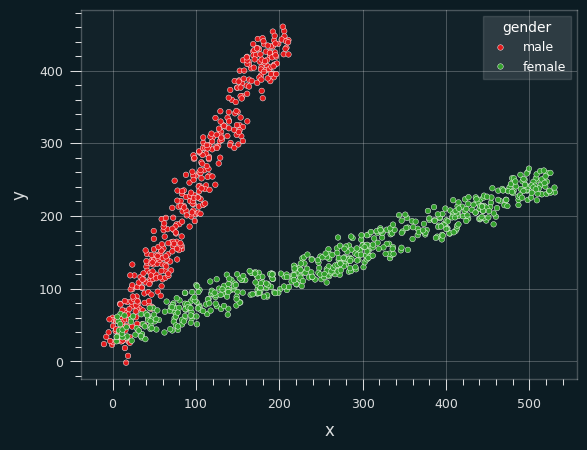

In [55]:
sns.scatterplot(data=df, x='x', y='y', hue='gender')

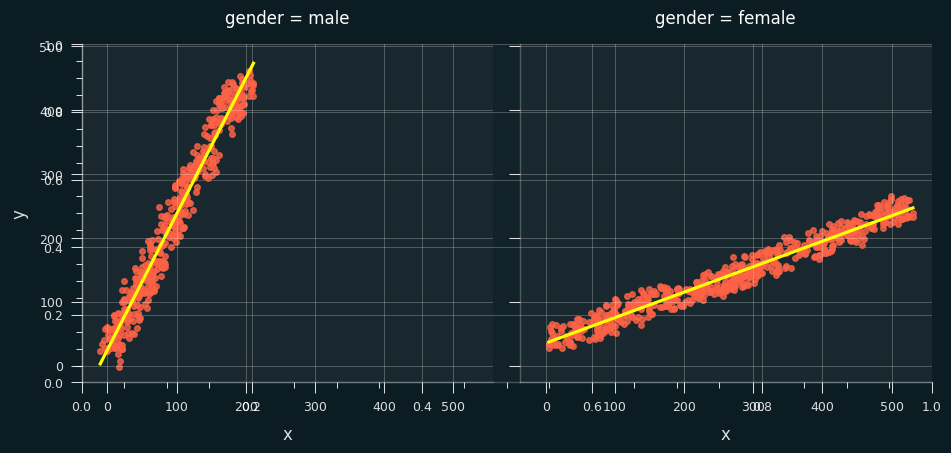

In [68]:
sns.lmplot(data=df, x='x', y='y',
           col='gender',
           scatter_kws={"color": "tomato"},
           line_kws={"color": "yellow"})

In [58]:
male, female = 0, 1
df.loc[:, 'encoded_gender'] = df['gender'].replace( {'male': male, 'female': female} )
df.loc[:, 'gender_fe'] = df['encoded_gender'] * df['x']

C:\Users\daith\AppData\Local\Temp\ipykernel_17692\195041774.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, 'encoded_gender'] = df['gender'].replace( {'male': male, 'female': female} )


In [63]:
features = ['x', 'encoded_gender', 'gender_fe']
target = 'y'

X, y = df[features], df[target]

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [65]:
model_equation(model, ['x', 'gender', 'gender_fe'], 'y')

x1 = x
x2 = gender
x3 = gender_fe
y = y


'y = 2.12 * x1 + 10.49 * x2 - 1.73 * x3 + 24.91'

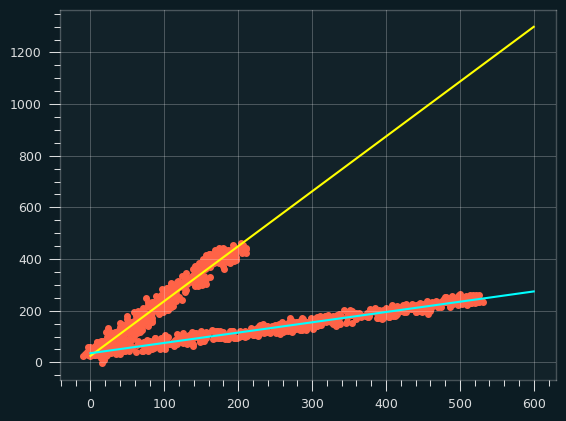

In [75]:
w, b = model.coef_, model.intercept_
x = np.arange(0, 601)
male_x = np.zeros_like(x)
female_x = np.ones_like(x)

male_equation = np.array( list(zip(x, male_x, male_x * x)) ) @ w + b
female_equation = np.array( list(zip(x, female_x, female_x * x)) ) @ w + b


plt.scatter(df['x'], df['y'], color="tomato")
plt.plot(x, male_equation, color="yellow")
plt.plot(x, female_equation, color="cyan")

In [86]:
male_ds = df[df['encoded_gender'] == male]
female_ds = df[df['encoded_gender'] == female]

male_acc = r2_score(male_ds['y'], model.predict(male_ds[features]))
female_acc = r2_score(female_ds['y'], model.predict(female_ds[features]))
overall_acc = r2_score(y, model.predict(X))

print(f"The accuracy for Male class: {male_acc * 100:.2f}")
print(f"The accuracy for Female class: {female_acc * 100:.2f}")
print(f"The overall accuracy: {overall_acc * 100:.2f}")

The accuracy for Male class: 95.61
The accuracy for Female class: 95.31
The overall accuracy: 96.31


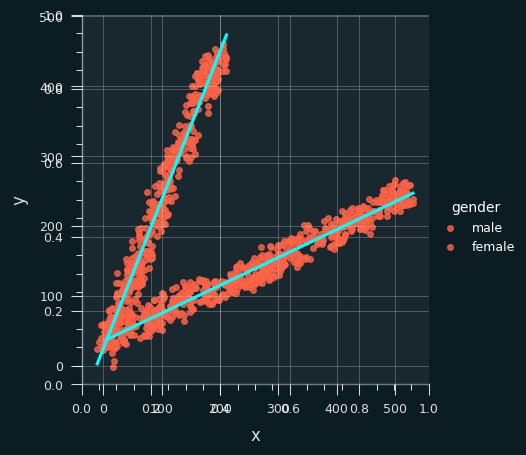

In [84]:
sns.lmplot(
    data=df,
    x='x', y='y',
    hue="gender",
    line_kws={"color": "cyan"},
    scatter_kws={"color": "tomato"},
)